# Results, section 3:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import statsmodels.api as sm

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
from func import run_corr, get_fdr_p, get_cmap, perc_dev, get_fdr_p_df

In [3]:
train_test_str = 'squeakycleanExclude' # 'squeakycleanExclude' 'trte_psychopathology'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer'
parc_scale = 400
primary_covariate = 'ageAtScan1_Years'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400/ageAtScan1_Years+sex_adj'

In [5]:
metrics = ('ct', 'vol')
phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')

## Load data pre-nispat data

In [6]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df.set_index(['bblid', 'scanid'], inplace = True); print(df.shape)
df_node = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

(410, 19)
(983, 19)


## Age effects

In [7]:
# regress out sex
df_nuis = df_train.loc[:,'sex_adj']
df_nuis = sm.add_constant(df_nuis)

cols = df_node_train.columns
mdl = sm.OLS(df_node_train.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node_train.loc[:,cols] = df_node_train.loc[:,cols] - y_pred

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'spearmanr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha

In [9]:
age_filter.sum()

618

## Load nispat outputs

In [10]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns)

In [11]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)

In [12]:
smse_filter.sum()

762

In [13]:
region_filter = np.logical_and(age_filter,smse_filter)
region_filter.sum()

607

### The interpretation of the z-deviations varies as a function of the age-effect from which the normative model is primarily derived.
### For instance, if the normative model predicts a _decrease_ in y with age, then _positive deviations_ may be interpreted as a **_delay_** in this maturational reduction, wheras _negative deviations_ may be interpreted as an _advancement_ in this maturational reduction.
### However, if the normative model predicts an _increase_ in y with age, then the interpretation of the deviations is reversed. That is:
#### IF predicted change = negative: _positive deviations_ = **_delay_** || _negative deviations_ = **_advance_**
#### IF predicted change = positive: _positive deviations_ = **_advance_** || _negative deviations_ = **_delay_**

In [14]:
# boolean that designates which regions carry with positive predicted change.
nm_is_pos = df_age_effect['coef'] > 0
print('Percentage of regions flipp by metric')
for metric in metrics:
    print(metric + ': ' + str(nm_is_pos.filter(regex = metric).sum() / num_parcels * 100))

# flipping the z-stats in these regions has the effect of standardising their interpration across the brain to be inline
# with the negative predicted change statement above
df_z.loc[:,nm_is_pos] = df_z.loc[:,nm_is_pos] * -1

Percentage of regions flipp by metric
ct: 7.249999999999999
vol: 12.0


## Get pheno-nispat relationships

In [15]:
df_pheno_z = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno_z.csv'))
df_pheno_z.set_index(['pheno','node'], inplace = True)

In [16]:
print(str(np.sum(df_pheno_z['sig_age_smse'])) + ' significant effects (fdr)')

478 significant effects (fdr)


In [17]:
for pheno in phenos:
    print(pheno + ': ' + str(np.sum(df_pheno_z.loc[pheno]['sig_age_smse'] == True)) + ' significant effects (fdr)')

Overall_Psychopathology: 65 significant effects (fdr)
Psychosis_Positive: 148 significant effects (fdr)
Psychosis_NegativeDisorg: 97 significant effects (fdr)
AnxiousMisery: 45 significant effects (fdr)
Externalizing: 65 significant effects (fdr)
Fear: 58 significant effects (fdr)


# Plots

In [18]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')
phenos_label_short = ('Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear')
phenos_label = ('Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear')
metrics = ('ct', 'vol')
metrics_label_short = ('Thickness', 'Volume')
metrics_label = ('Thickness', 'Volume')

print(phenos)
print(metrics)

metrics_labels = list()
for metric in metrics:
    tmp_labels = [metric + '_' + str(i) for i in range(num_parcels)]
    metrics_labels = metrics_labels + tmp_labels

('Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear')
('ct', 'vol')


### Calculate node summary metrics

In [19]:
z_thr = 2.6    
# percent of supra-threshold (cf. Wolfers et al. JAMA Psych)
node_z_perc_p = perc_dev(df_z.transpose(), thr = z_thr, sign = 'pos')
node_z_perc_n = perc_dev(df_z.transpose(), thr = z_thr, sign = 'neg')

In [20]:
for metric in metrics:
    roi_data = node_z_perc_p[region_filter].filter(regex = metric)
    print('max +ve % for ' + metric + ': ' + str(np.round(roi_data.max(),2)))
    print('count of +ve deviations >2% for ' + metric + ': ' + str(np.sum(roi_data > 2)))
    print('count of +ve deviations >1.5% for ' + metric + ': ' + str(np.sum(roi_data > 1.5)))
    roi_data = node_z_perc_n[region_filter].filter(regex = metric)
    print('max -ve % for ' + metric + ': ' + str(np.round(roi_data.max(),2)))
    print('count of -ve deviations >2% for ' + metric + ': ' + str(np.sum(roi_data > 2)))
    print('count of -ve deviations >1.5% for ' + metric + ': ' + str(np.sum(roi_data > 1.5)))
    print()

max +ve % for ct: 2.95
count of +ve deviations >2% for ct: 6
count of +ve deviations >1.5% for ct: 38
max -ve % for ct: 2.44
count of -ve deviations >2% for ct: 2
count of -ve deviations >1.5% for ct: 17

max +ve % for vol: 2.14
count of +ve deviations >2% for vol: 1
count of +ve deviations >1.5% for vol: 14
max -ve % for vol: 2.34
count of -ve deviations >2% for vol: 1
count of -ve deviations >1.5% for vol: 5



In [21]:
for metric in metrics:
    r = sp.stats.spearmanr(node_z_perc_p[region_filter].filter(regex = metric), node_z_perc_n[region_filter].filter(regex = metric))
    if r[1] < .001:
        print(metric + ': ' + str(np.round(r[0],2)) + ', ' + str(np.round(r[1],3)))

ct: -0.28, 0.0
vol: -0.24, 0.0


In [22]:
r = pd.DataFrame(index = metrics, columns = phenos)
p = pd.DataFrame(index = metrics, columns = phenos)

for pheno in phenos:
    for metric in metrics:
        pheno_data = df_pheno_z.loc[pheno].loc[region_filter,'coef'].filter(regex = metric)
        roi_data = node_z_perc_p[region_filter].filter(regex = metric)
#         roi_data = node_z_perc_n[region_filter].filter(regex = metric)
        r.loc[metric,pheno] = sp.stats.spearmanr(pheno_data, roi_data)[0]
        p.loc[metric,pheno] = sp.stats.spearmanr(pheno_data, roi_data)[1]
p = get_fdr_p_df(p, alpha = 0.05)

In [23]:
r[p<.05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,NaN,NaN,NaN,NaN,NaN,0.333475
vol,NaN,NaN,NaN,NaN,NaN,NaN


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


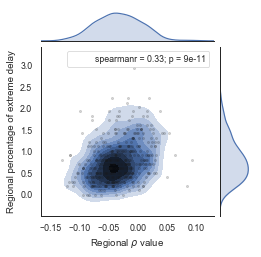

In [24]:
pheno = 'Fear'
metric = 'ct'
pheno_data = df_pheno_z.loc[pheno].loc[region_filter,'coef'].filter(regex = metric)
roi_data = node_z_perc_p[region_filter].filter(regex = metric)

f = sns.jointplot(x = pheno_data, y = roi_data, kind="kde")
f.fig.set_figwidth(3.25)
f.fig.set_figheight(3.25)
f.set_axis_labels('Regional $\\rho$ value', 'Regional percentage of extreme delay')
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 3, linewidth = 2, marker = ".", alpha = 0.25)
f.ax_joint.collections[0].set_alpha(0)
f.savefig('corr_spatial_' + pheno + '_' + metric + '_z.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Overlap between individuals

### Calculate subject summary metrics

In [25]:
# percent of supra-threshold (cf. Wolfers et al. JAMA Psych)
for metric in metrics:
    # percent of supra-threshold (cf. Wolfers et al. JAMA Psych)
    df[metric + '_z_perc-p'] = perc_dev(df_z.filter(regex = metric), thr = z_thr, sign = 'pos')
    df[metric + '_z_perc-n'] = perc_dev(df_z.filter(regex = metric), thr = z_thr, sign = 'neg')

In [26]:
pos_bol = df['ct_z_perc-p'] > 0 # vectors of people with non-zero 0 percentages extreme positive deviations
neg_bol = df['ct_z_perc-n'] > 0 # vectors of people with non-zero 0 percentages extreme negative deviations
sp.spatial.distance.jaccard(pos_bol, neg_bol)

0.5927654609101517

In [27]:
pos_bol = df['vol_z_perc-p'] > 0 # vectors of people with non-zero 0 percentages extreme positive deviations
neg_bol = df['vol_z_perc-n'] > 0 # vectors of people with non-zero 0 percentages extreme negative deviations
sp.spatial.distance.jaccard(pos_bol, neg_bol)

0.5094972067039106

## Brain plots nispat

In [28]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [29]:
subject_id = 'fsaverage'

In [30]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get_cmap', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Brain plots - overlap maps

In [31]:
for metric in metrics:
    cut_pos = node_z_perc_p.filter(regex = metric).mean()
    cut_neg = node_z_perc_n.filter(regex = metric).mean()
    
    for hemi in ('lh', 'rh'):
        for i in range(2):

            if i == 0:
                fig_str = hemi + '_' + metric + '_z_perc_p'
                roi_data = node_z_perc_p.filter(regex = metric).values
            elif i == 1:
                fig_str = hemi + '_' + metric + '_z_perc_n'
                roi_data = node_z_perc_n.filter(regex = metric).values

            parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NeuroDev_NetworkControl/figs/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'].values < age_alpha
            smse_filt = df_smse.filter(regex = metric, axis = 0).values < smse_thresh
            smse_filt = smse_filt.reshape(-1)
            region_filt = np.logical_and(age_filt,smse_filt)

            # Threshold
            roi_data[roi_data == 0] = -1000
            roi_data[~region_filt] = -1000
            if metric == 'ct':
                center_anchor = 2.5
            elif metric == 'vol':
                center_anchor = 2.5

            if np.var(roi_data) > 0:
                # project subject's data to vertices
                brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'hot', center_anchor = center_anchor)
            else:
                print('Nothing significant')

colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)
colormap sequential: [0.00e+00, 1.25e+00, 2.50e+00] (opaque)


In [32]:
%matplotlib inline

Figure 4

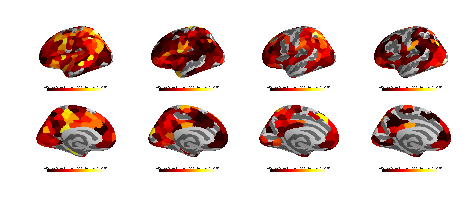

In [33]:
f, axes = plt.subplots(2, 4)
f.set_figwidth(8)
f.set_figheight(3)
plt.subplots_adjust(wspace=0, hspace=0)

# column 0:
hemi = 'lh'
fig_str = hemi + '_ct_z_perc_p.png'
try:
#     axes[0,0].set_title('Thickness (END)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = hemi + '_ct_z_perc_n.png'
try:
#     axes[0,1].set_title('Thickness (EPD)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')
    
# column 2:
fig_str = hemi + '_vol_z_perc_p.png'
try:
#     axes[0,2].set_title('Strength (END)')
    image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
except FileNotFoundError: axes[0,2].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
except FileNotFoundError: axes[1,2].axis('off')
    
# column 3:
fig_str = hemi + '_vol_z_perc_n.png'
try:
#     axes[0,3].set_title('Strength (EPD)')
    image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
except FileNotFoundError: axes[0,3].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
except FileNotFoundError: axes[1,3].axis('off')

plt.show()
# f.savefig('brain_plot_tiled_perc_pn_'+hemi+'.png', dpi = 600, bbox_inches = 'tight', pad_inches = 0)
f.savefig('brain_plot_tiled_perc_pn_'+hemi+'.svg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0)